imports

In [2]:
import io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

inspecting the dataset

In [3]:
with open("data/bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

hyperparameters

In [4]:
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

loading and preprocessing dataset

In [5]:
data_dir = "data/bbc-text.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (2225, 2)
['tech'
 'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv

In [6]:
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")
print(f"First sentence has {len((data[0,1]).split())} words.\n")
print(f"The first 5 labels are {data[:5,0]}")

There are 2225 sentence-label pairs in the dataset.

First sentence has 737 words.

The first 5 labels are ['tech' 'business' 'sport' 'sport' 'entertainment']


splitting the dataset

In [7]:
def train_val_datasets(data):
   
    train_size = int(len(data) * TRAINING_SPLIT)
    
    texts = data[:, 1]
    
    labels = data[:, 0]
    
    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))
    
    
    return train_dataset, validation_dataset

In [8]:
train_dataset, validation_dataset = train_val_datasets(data)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.



I0000 00:00:1755271163.096882    6403 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5017 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


vectorization , sequencing and padding

In [9]:
def standardize_func(sentence):
   
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]
 
    sentence = tf.strings.lower(sentence)
    
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")
    
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")

    return sentence

In [10]:
test_sentence = "Hello! We're just about to see this function in action =)"
standardized_sentence = standardize_func(test_sentence)
print(f"Original sentence is:\n{test_sentence}\n\nAfter standardizing:\n{standardized_sentence}")

Original sentence is:
Hello! We're just about to see this function in action =)

After standardizing:
b'hello  just   see  function  action '


using fit vectorizer

In [11]:
def fit_vectorizer(train_sentences, standardize_func):
    
    vectorizer = tf.keras.layers.TextVectorization( 
		standardize=standardize_func,
		max_tokens=VOCAB_SIZE,
		output_sequence_length=MAX_LENGTH
	) 
    
    vectorizer.adapt(train_sentences)
	
    
    return vectorizer

In [12]:
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1000 words



2025-08-15 21:21:50.543055: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


label encoder

In [13]:
def fit_label_encoder(train_labels, validation_labels):
    
    labels = train_labels.concatenate(validation_labels)
    
    label_encoder = tf.keras.layers.StringLookup(
        num_oov_indices=0, 
        mask_token=None     
    )
    
    label_encoder.adapt(labels)
        
    return label_encoder

In [14]:
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
                                  
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: [np.str_('sport'), np.str_('business'), np.str_('politics'), np.str_('tech'), np.str_('entertainment')]


2025-08-15 21:59:31.222331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


preprocessing for real this time

In [15]:
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    
    def preprocess(text, label):
        text = text_vectorizer(text)
        label = label_encoder(label)
        return text, label
    
    dataset = dataset.map(preprocess)
    
    dataset = dataset.batch(32)
        
    return dataset

In [16]:
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

print(f"Number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"Number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

Number of batches in the train dataset: 56
Number of batches in the validation dataset: 14


In [17]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


building and training the final model

In [18]:
def create_model():
   
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape=(MAX_LENGTH,)),
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
		loss='sparse_categorical_crossentropy',
		optimizer='adam',
		metrics=['accuracy'] 
	) 

    return model

In [19]:
model = create_model()

In [20]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30


I0000 00:00:1755275550.544457    7268 service.cc:152] XLA service 0x7ff61c003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755275550.544470    7268 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-15 22:02:30.592256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755275550.706778    7268 cuda_dnn.cc:529] Loaded cuDNN version 91002


11/56 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2447 - loss: 1.6075

I0000 00:00:1755275551.701977    7268 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2540 - loss: 1.6011 - val_accuracy: 0.3596 - val_loss: 1.5741
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4347 - loss: 1.5548 - val_accuracy: 0.4787 - val_loss: 1.4999
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4886 - loss: 1.4631 - val_accuracy: 0.6742 - val_loss: 1.3684
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6519 - loss: 1.3132 - val_accuracy: 0.7371 - val_loss: 1.1902
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7347 - loss: 1.1218 - val_accuracy: 0.8382 - val_loss: 0.9829
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8260 - loss: 0.8987 - val_accuracy: 0.8921 - val_loss: 0.7748
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8935 - loss: 0.6904 - val_accuracy: 0.9011 - val_loss: 0.6229
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9280 - loss: 0.5378 - val_accuracy: 0.9146 - val_loss: 0.

visualizing the results

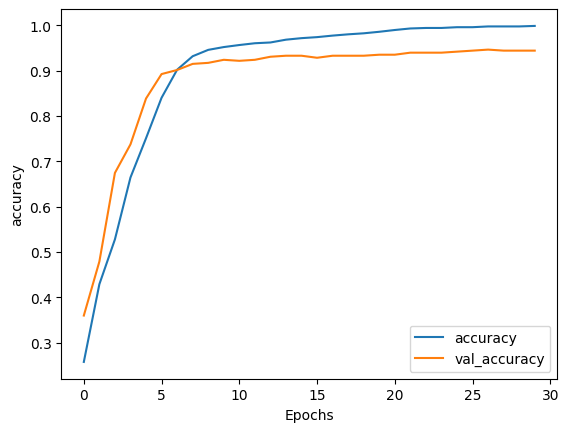

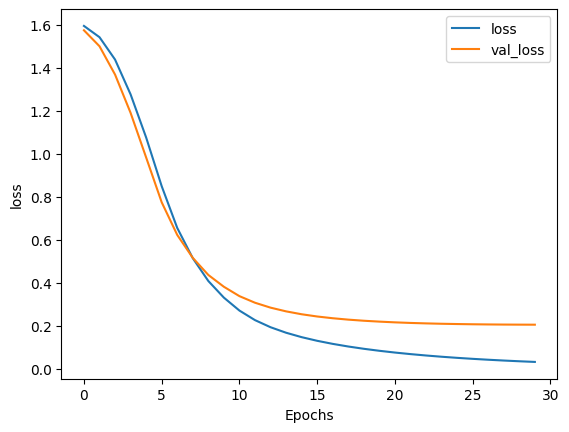

In [21]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

sexy results ain't gonna lie

In [22]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

saving the embeddings for tensorflow projector

In [23]:
embedding = model.layers[0]

with open('./metadata.tsv', "w") as f:
    for word in vectorizer.get_vocabulary():
        f.write("{}\n".format(word))
weights = tf.Variable(embedding.get_weights()[0][1:])

with open('./weights.tsv', 'w') as f: 
    for w in weights:
        f.write('\t'.join([str(x) for x in w.numpy()]) + "\n")